In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

NOTE: Significant amounts of this code have been adopted from Kotliar et al, Cell 2020 - namely running MAST on a scanpy adata object. Please cite the orignial authors if using Dylan's MAST code.

In [2]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'SubclusteringV2_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups

In [3]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['Neutrophils']), :]
adata

View of AnnData object with n_obs × n_vars = 5250 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'SubclusteringV2_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [2]:
import os
adir = "./Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs"
project_name = 'File_NEW'
gcs = False
abase = os.path.join(adir, project_name)
results_dir = './Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/results'

In [3]:
dedir = os.path.join(adir, 'DE_Stage')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [4]:
import palettable
from IPython.display import display
from joblib import parallel_backend
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from matplotlib import gridspec

In [8]:
adata_raw=adata
set(list(adata.obs.Subclustering))


{'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils',
 'SORL1$^{hi}$, CFD$^{hi}$  Neutrophils'}

In [9]:
labmap = {
'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils':"ICAM1NBNNeutrophils",
'SORL1$^{hi}$, CFD$^{hi}$  Neutrophils':"SORL1CFDNeutrophils"}
       
adata_raw.obs['Detailed_Subclustering_Neutrohils'] = adata_raw.obs['Subclustering'].replace(labmap)


In [10]:
list(set(adata_raw.obs['Detailed_Subclustering_Neutrohils'] ))

['SORL1CFDNeutrophils', 'ICAM1NBNNeutrophils']

In [12]:
#adata_raw=adata_12
adata_raw.raw = adata_raw.copy()

In [11]:
cts = ['SORL1CFDNeutrophils', 'ICAM1NBNNeutrophils']
test_periods = ["IgG", "Naïve", "antiCD4"]

for ct in cts:
    for test_period in test_periods:
        ind = (adata_raw.obs['Detailed_Subclustering_Neutrohils']==ct) & (adata_raw.obs['Group_Detailed'].isin(['IgG', test_period]))
        adata_ct = adata_raw[ind,:].copy()
        adata_ct.obs['Group_Detailed_Binary'] = adata_ct.obs['Group_Detailed'].replace({'IgG':0, test_period:1})        
        #adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
        adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
        sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
        adata_ct.obs['cngeneson'] =  scale(np.asarray((adata_ct.X>0).sum(axis=1)).reshape(-1))       
        sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
        sc.pp.log1p(adata_ct)
        X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
        X.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'))
        adata_ct.obs.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'))
        adata_ct.var.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv'))

In [12]:
ncores =4
testvar = 'Group_Detailed_Binary'
covars = ['cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

for ct in cts:
    for test_period in test_periods:
        exprfn = os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv')
        celldatfn = os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv')
        genedatfn = os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv')
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        cmd = 'Rscript ./run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
        print(cmd)
        !{cmd}

Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/DE_Stage/genefiles/SORL1CFDNeutrophils.IgG.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/DE_Stage/genefiles/SORL1CFDNeutrophils.IgG.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/DE_Stage/genefiles/SORL1CFDNeutrophils.IgG.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/DE_Stage/results/SORL1CFDNeutrophils.IgG.DE.csv 4 Group_Detailed_Binary cngeneson,percent_mito_scale
~Group_Detailed_Binary + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et i

In [13]:
allres = []
cts = ['SORL1CFDNeutrophils', 'ICAM1NBNNeutrophils']
test_periods = ["Naïve", "antiCD4"]
for ct in cts:
    for test_period in test_periods:
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        res = pd.read_csv(resultsfn)
        res.index = res['primerid']
        res['logP'] = res['P_H'].apply(np.log10)*-1
        (_,q,_,_) = multipletests(res['P_H'].dropna(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        res['Q'] = np.nan
        res.loc[~res['P_H'].isnull(), 'Q'] = q
        res['logQ'] = res['Q'].apply(np.log10)*-1
        res = res[['logFC', 'P_H', 'logP', 'Q', 'logQ']]
        expr = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'), index_col=0)
        obs = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'), index_col=0)
        logFC2 = expr.loc[:,obs['Group_Detailed']==test_period].mean(axis=1)-expr.loc[:,obs['Group_Detailed']!=test_period].mean(axis=1)
        res['logFC_unadjusted'] = logFC2
        res['logFC_combined'] = res['logFC'].copy()
        ind = res['logFC'].isnull()
        res.loc[ind, 'logFC_combined'] = res.loc[ind, 'logFC_unadjusted']        
        res.columns = [(ct, test_period, x) for x in res.columns]
        allres.append(res)
        
allres = pd.concat(allres, axis=1)
allres.columns = pd.MultiIndex.from_tuples(allres.columns)


In [14]:
allres.head()


SORL1CFDNeutrophils                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT              0.047790  0.087265  1.059161  0.325620  0.487289   
AAGAB              -0.039555  0.113786  0.943911  0.380936  0.419148   
AAK1                0.008798  0.646766  0.189253  0.910775  0.040589   
AAMP               -0.010481  0.725321  0.139470  0.947800  0.023283   
AARS               -0.010841  0.650662  0.186644  0.914539  0.038798   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT           0.044648       0.047790  0.006144  0.893960  0.048682  ...   
AAGAB           -0.056930      -0.039555 -0.011170  0.172980  0.762005  ...   
AAK1            -0.019694       0.008798  0.003507  0.948286  0.023060  ...   
AAMP            -0.062264      -0.010481  0.040548  0.309288  0.509637  ...   
AARS            -0.039951      -0.010841  0.014088  0.369924  0.431887  ...   

         ICAM1NBNNeutrophils                                            \
                       Naïve                                   antiCD4   
                        logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                 
A4GALT              0.143473         0.284948       0.264926  0.106842   
AAGAB                    NaN              NaN            NaN       NaN   
AAK1                0.045841        -0.014643      -0.010802 -0.008532   
AAMP                0.080386         0.057536       0.057536       NaN   
AARS                0.084894        -0.149515      -0.049924 -0.032681   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.488968  0.310720  0.861437  0.064777         0.113675   
AAGAB     0.600714  0.221332  0.861437  0.064777         0.025695   
AAK1      0.812538  0.090156  0.911032  0.040466         0.001497   
AAMP      0.235787  0.627480  0.861437  0.064777         0.078561   
AARS      0.768913  0.114123  0.892207  0.049534        -0.054424   

                         
                         
         logFC_combined  
primerid                 
A4GALT         0.106842  
AAGAB          0.025695  
AAK1          -0.008532  
AAMP           0.078561  
AARS          -0.032681  

[5 rows x 28 columns]

In [15]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres.to_csv(mergefn)


In [7]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
allres.head()


SORL1CFDNeutrophils                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT              0.047790  0.087265  1.059161  0.325620  0.487289   
AAGAB              -0.039555  0.113786  0.943911  0.380936  0.419148   
AAK1                0.008798  0.646766  0.189253  0.910775  0.040589   
AAMP               -0.010481  0.725321  0.139470  0.947800  0.023283   
AARS               -0.010841  0.650662  0.186644  0.914539  0.038798   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT           0.044648       0.047790  0.006144  0.893960  0.048682  ...   
AAGAB           -0.056930      -0.039555 -0.011170  0.172980  0.762005  ...   
AAK1            -0.019694       0.008798  0.003507  0.948286  0.023060  ...   
AAMP            -0.062264      -0.010481  0.040548  0.309288  0.509637  ...   
AARS            -0.039951      -0.010841  0.014088  0.369924  0.431887  ...   

         ICAM1NBNNeutrophils                                            \
                       Naïve                                   antiCD4   
                        logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                 
A4GALT              0.143473         0.284948       0.264926  0.106842   
AAGAB                    NaN              NaN            NaN       NaN   
AAK1                0.045841        -0.014643      -0.010802 -0.008532   
AAMP                0.080386         0.057536       0.057536       NaN   
AARS                0.084894        -0.149515      -0.049924 -0.032681   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.488968  0.310720  0.861437  0.064777         0.113675   
AAGAB     0.600714  0.221332  0.861437  0.064777         0.025695   
AAK1      0.812538  0.090156  0.911032  0.040466         0.001497   
AAMP      0.235787  0.627480  0.861437  0.064777         0.078561   
AARS      0.768913  0.114123  0.892207  0.049534        -0.054424   

                         
                         
         logFC_combined  
primerid                 
A4GALT         0.106842  
AAGAB          0.025695  
AAK1          -0.008532  
AAMP           0.078561  
AARS          -0.032681  

[5 rows x 28 columns]

In [8]:
allres

SORL1CFDNeutrophils                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT              0.047790  0.087265  1.059161  0.325620  0.487289   
AAGAB              -0.039555  0.113786  0.943911  0.380936  0.419148   
AAK1                0.008798  0.646766  0.189253  0.910775  0.040589   
AAMP               -0.010481  0.725321  0.139470  0.947800  0.023283   
AARS               -0.010841  0.650662  0.186644  0.914539  0.038798   
...                      ...       ...       ...       ...       ...   
ZNF333                   NaN       NaN       NaN       NaN       NaN   
ZNF397                   NaN       NaN       NaN       NaN       NaN   
ZNF717                   NaN       NaN       NaN       NaN       NaN   
ZNF790                   NaN       NaN       NaN       NaN       NaN   
ZNF84                    NaN       NaN       NaN       NaN       NaN   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT           0.044648       0.047790  0.006144  0.893960  0.048682  ...   
AAGAB           -0.056930      -0.039555 -0.011170  0.172980  0.762005  ...   
AAK1            -0.019694       0.008798  0.003507  0.948286  0.023060  ...   
AAMP            -0.062264      -0.010481  0.040548  0.309288  0.509637  ...   
AARS            -0.039951      -0.010841  0.014088  0.369924  0.431887  ...   
...                   ...            ...       ...       ...       ...  ...   
ZNF333                NaN            NaN       NaN       NaN       NaN  ...   
ZNF397                NaN            NaN       NaN       NaN       NaN  ...   
ZNF717                NaN            NaN       NaN       NaN       NaN  ...   
ZNF790                NaN            NaN       NaN       NaN       NaN  ...   
ZNF84                 NaN            NaN       NaN       NaN       NaN  ...   

         ICAM1NBNNeutrophils                                            \
                       Naïve                                   antiCD4   
                        logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                 
A4GALT              0.143473         0.284948       0.264926  0.106842   
AAGAB                    NaN              NaN            NaN       NaN   
AAK1                0.045841        -0.014643      -0.010802 -0.008532   
AAMP                0.080386         0.057536       0.057536       NaN   
AARS                0.084894        -0.149515      -0.049924 -0.032681   
...                      ...              ...            ...       ...   
ZNF333                   NaN              NaN            NaN       NaN   
ZNF397                   NaN              NaN            NaN       NaN   
ZNF717                   NaN              NaN            NaN       NaN   
ZNF790                   NaN              NaN            NaN       NaN   
ZNF84                    NaN              NaN            NaN -0.057626   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.488968  0.310720  0.861437  0.064777         0.113675   
AAGAB     0.600714  0.221332  0.861437  0.064777         0.025695   
AAK1      0.812538  0.090156  0.911032  0.040466         0.001497   
AAMP      0.235787  0.627480  0.861437  0.064777         0.078561   
AARS      0.768913  0.114123  0.892207  0.049534        -0.054424   
...       

In [9]:
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

In [10]:
allres_P = allres.xs('P_H', axis=1, level=2)
allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

In [11]:
issig = (allres_Q<q_thresh) &  (allres_FC.abs() > log_FC_thresh)
issig.sum(axis=0)

SORL1CFDNeutrophils  Naïve      353
                     antiCD4    301
ICAM1NBNNeutrophils  Naïve       41
                     antiCD4     20
dtype: int64

END implementation of Kotliar et al MAST

In [29]:
issig.to_csv("././IsSig_TNK_MAST_DE_Aug23_test.csv")

In [20]:
#plot the NHP cohorts seperately (eg seperate plots for Naive vs IgG and aCD4 vs IgG)
from matplotlib.patches import Rectangle
# cell types order
cell_types_to_plot = [
'SORL1CFDNeutrophils', 'ICAM1NBNNeutrophils'
]
def plot_group(data, issig_data, group_name, genes_of_interest, save=None, flip_direction=False):
    display_data = data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    issig_display = issig_data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    '''
    - data input: MAST allres_FC
    
    - issig_data must be calculated before running
    
    - to make the data more "biologically"interpretable/easy to read the figure since everything is 
      WRT to IgG we can transform the data by multiplying by -1 (these are the MAST allres_FC data
        - the non-"flipped" data can also be plotted, if desired. use "flip_direction" do define
    '''
    if flip_direction:
        display_data = display_data * -1
    
    cmap = 'RdBu_r'
    cell_type_colors = {cell_type: f"C{i}" for i, cell_type in enumerate(cell_types_to_plot)}
    fig, ax = plt.subplots(figsize=(1.75, 9))
    display_data = display_data[cell_types_to_plot]
    issig_display = issig_display[cell_types_to_plot]
    sns.heatmap(display_data, ax=ax, cmap=cmap, vmin=-0.5, vmax=0.5, cbar_kws={'label': 'log$_{e}$FC'})
    ax.set_xticks(np.arange(display_data.shape[1]) + 0.5)
    ax.set_xticklabels(display_data.columns, rotation=90, ha='center', fontsize=16)
    ax.set_yticklabels(display_data.index, rotation=0, fontsize=15, fontstyle='italic')
    ax.tick_params(axis='both', which='both', length=0)
    for xtick in ax.get_xticklabels():
        label_text = xtick.get_text()  
        color = cell_type_colors.get(label_text, 'black')  
        xtick.set_color(color)
    threshold_value = log_FC_thresh
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            if abs(display_data.iloc[y, x]) > threshold_value:
                ax.plot(x + 0.5, y + 0.5, 'o', ms=5, mec='none', mfc='white')
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            col = display_data.columns[x]
            row = display_data.index[y]
            if issig_display.at[row, col]:
                ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=2))
                
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    #note these are hard coded and will need to be changed for each plot
    if flip_direction:
        plt.title(f"{group_name} (IgG vs. Naive)")
        ax.set_ylabel("log$_{e}$FC (IgG vs. Naive)")
    else:
        plt.title(f"{group_name} (Naive vs. IgG)")
        ax.set_ylabel("log$_{e}$FC (Naive vs. IgG)")
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight')
    else:
        plt.show()

             
cytokines_chemokines = ["CXCL8", "IL1R1", "IL1R2", "CXCR1", "CXCR2", "CXCR4", "CCL3L1", "SERPINB1", "CXCL16", "CCL3"]
inflammatory_response = ["TNF", "IL6R", "CASP1", "NFAM1", "IFNGR1", "NLRP3", "STAT1", "STAT3", "NFKBIA"]
neutrophil_activation_function = ["FCGR2B", "CD177", "LTF", "MMP9"]
signal_transduction = ["SYK", "RAC2"]
other_relevant_functions = ["ARG1", "HIF1A", "S100A8", "S100A9"]
netosis = ["MPO", "NE", "PADI4"]
degranulation = ["CTSG", "CD63", "LAMP2"]
antimicrobial_response = ["BPI", "DEFA1"]

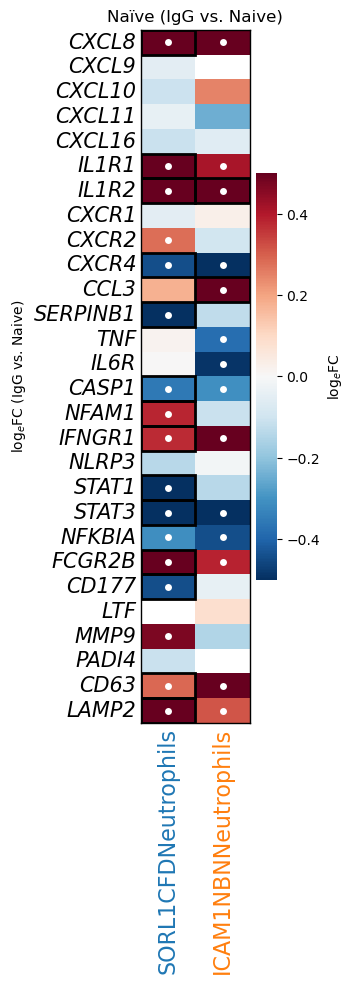

In [21]:
# naive vs igg neutrophil plot
show_genes = ["CXCL8",'CXCL9',"CXCL10","CXCL11","CXCL16","IL1R1", "IL1R2", "CXCR1", "CXCR2", "CXCR4","CCL3","SERPINB1","TNF", "IL6R",
              "CASP1", "NFAM1", "IFNGR1", "NLRP3", "STAT1", "STAT3", "NFKBIA",
             "FCGR2B", "CD177", "LTF", "MMP9",
              "PADI4",
             "CD63", "LAMP2"
            ]

plot_group(allres_FC, issig, "Naïve", show_genes,save="/Users/joshuadavidbromley/Desktop/IMMUNITY_Figures_Final/Figure6/Fig6_Neutrophils_Naive_DE_genes_for_Publication.png",flip_direction=True)


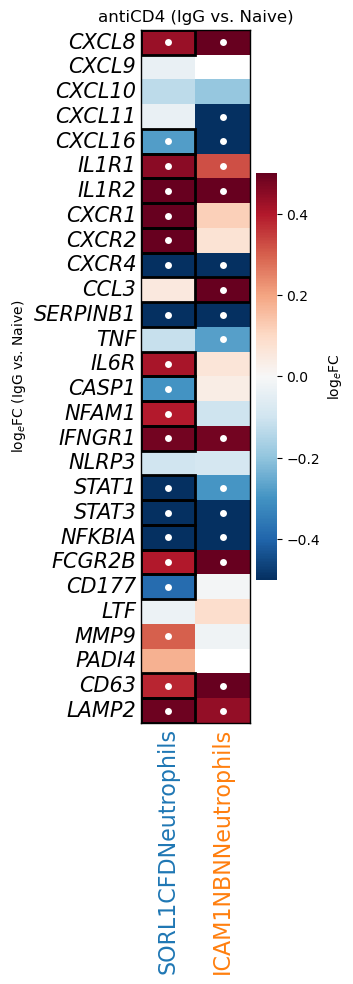

In [22]:
# antiCD4 vs IgG neutrophil plot
#note the IgG vs Naive are hard coded and will need to be changed for each plot (should be IgG vs aCD4)
plot_group(allres_FC, issig, "antiCD4", show_genes,save="/Users/joshuadavidbromley/Desktop/IMMUNITY_Figures_Final/Figure6/Fig6_Macrophage_aCD4_DE_genes_for_Publication.png",flip_direction=True)


# Supplemental (Figure 6 associated) Extract number of DE genes per condtion

In [5]:
# MAST DE results
file_path = './Figure6/Excel_sheets/MAST_DE_Neutrophil_Outputs/DE_Stage/results/AllCT.AllPeriod.DE.Merged.csv'
allres = pd.read_csv(file_path, header=[0,1,2], index_col=0)

# reindex columns to specific cell types
allres = allres.reindex(columns=['ICAM1NBNNeutrophils', 'SORL1CFDNeutrophils'], level=0)

# define thresholds
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

# determine significant DE genes
issig = (allres_Q < q_thresh) & (allres_FC.abs() > log_FC_thresh)
issig2 = (allres_Q < q_thresh) & (allres_FC < -log_FC_thresh)
issig1 = (allres_Q < q_thresh) & (allres_FC > log_FC_thresh)

# annotate based on directionality (logFC values)
allres['up_in_Naïve'] = issig1.sum(axis=1)
allres['up_in_IgG'] = issig2.sum(axis=1)

# DF w/ significant DE genes
dfT_up = pd.DataFrame(issig1.sum(axis=0), columns=['Naïve'])
dfT_down = pd.DataFrame(issig2.sum(axis=0), columns=['IgG'])

dfT_combined = pd.concat([dfT_up, dfT_down], axis=1).fillna(0).reset_index()
df_naive = dfT_combined[dfT_combined['level_1'] == 'Naïve'].copy()
df_anticd4 = dfT_combined[dfT_combined['level_1'] == 'antiCD4'].copy()

# rename cols
df_naive.columns = ['Celltype', 'Comparison', 'Naïve', 'IgG']
df_anticd4.columns = ['Celltype', 'Comparison', 'antiCD4', 'IgG']

# drop 'comparison' column
df_naive.drop(columns=['Comparison'], inplace=True)
df_anticd4.drop(columns=['Comparison'], inplace=True)

# define cell type order and re-annotate (latex format)
celltype_order = [
    'ICAM1NBNNeutrophils', 'SORL1CFDNeutrophils'
]
celltype_annotations = {
'ICAM1NBNNeutrophils':'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils',
'SORL1CFDNeutrophils':'SORL1$^{hi}$, CFD$^{hi}$  Neutrophils'
}

df_naive['Celltype'] = pd.Categorical(df_naive['Celltype'], categories=celltype_order, ordered=True)
df_anticd4['Celltype'] = pd.Categorical(df_anticd4['Celltype'], categories=celltype_order, ordered=True)

df_naive.sort_values('Celltype', inplace=True)
df_anticd4.sort_values('Celltype', inplace=True)

df_naive['Celltype'] = df_naive['Celltype'].map(celltype_annotations)
df_anticd4['Celltype'] = df_anticd4['Celltype'].map(celltype_annotations)

import matplotlib.patches as patches
def plot_de_genes(df, group1, group2, plot_path, sum_group1, sum_group2):
    '''
    NOTE: the allres_FC is the |FC|
    '''
    df_melted = df.melt(id_vars=['Celltype'], value_vars=[group1, group2], var_name='Group', value_name='Value')
    fig, ax = plt.subplots(figsize=(10, 6))
    fg = sns.barplot(x='Celltype', y='Value', hue='Group', data=df_melted, palette=reinfection_palette, edgecolor='white')
    patch_positions = [i for i in range(len(df['Celltype'])) if i % 2 == 0]
    for pos in patch_positions:
        ax.add_patch(patches.Rectangle((pos - 0.5, ax.get_ylim()[0]), 1, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    plt.xticks(rotation=90, size=12)
    fg.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.tick_right()
    plt.yticks(size=12, rotation=0)
    plt.grid(False)
    plt.ylabel("Granuloma: #DE Genes\n (FDR<0.05, logFC>1.3)", size=14)
    plt.xlabel("")
    plt.legend(title="Group", fontsize=12, title_fontsize=14)
    sns.despine(left=False, bottom=False, right=False, top=False)
    for p in fg.patches:
        fg.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points', rotation=90)
    ax.text(len(df['Celltype']) - 0.1, ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15, 
            f'Sum {group1}: {sum_group1}\nSum {group2}: {sum_group2}', fontsize=12, 
            verticalalignment='top', rotation=90)
    plt.savefig(plot_path, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

sum_naive = df_naive['Naïve'].sum()
sum_igG_naive = df_naive['IgG'].sum()

sum_anticd4 = df_anticd4['antiCD4'].sum()
sum_igG_anticd4 = df_anticd4['IgG'].sum()

os.makedirs('./Reinfection_Figures_For_Publication/Figure6/', exist_ok=True)


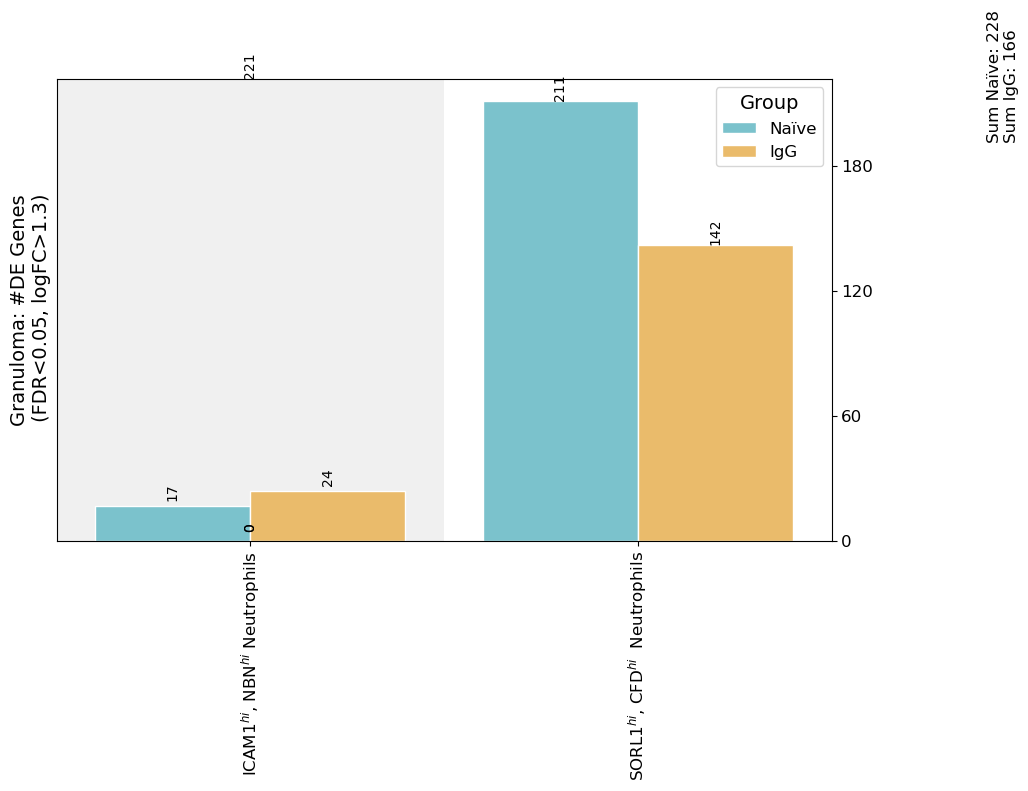

In [6]:
# Plot Naïve vs. IgG DE genes
plot_path_naive_vs_igg = './Reinfection_Figures_For_Publication/Figure6/Neuts_Associated_Supplemental_NumDEgenes_NaivevIgG.png'
plot_de_genes(df_naive, 'Naïve', 'IgG', plot_path_naive_vs_igg, sum_naive, sum_igG_naive)

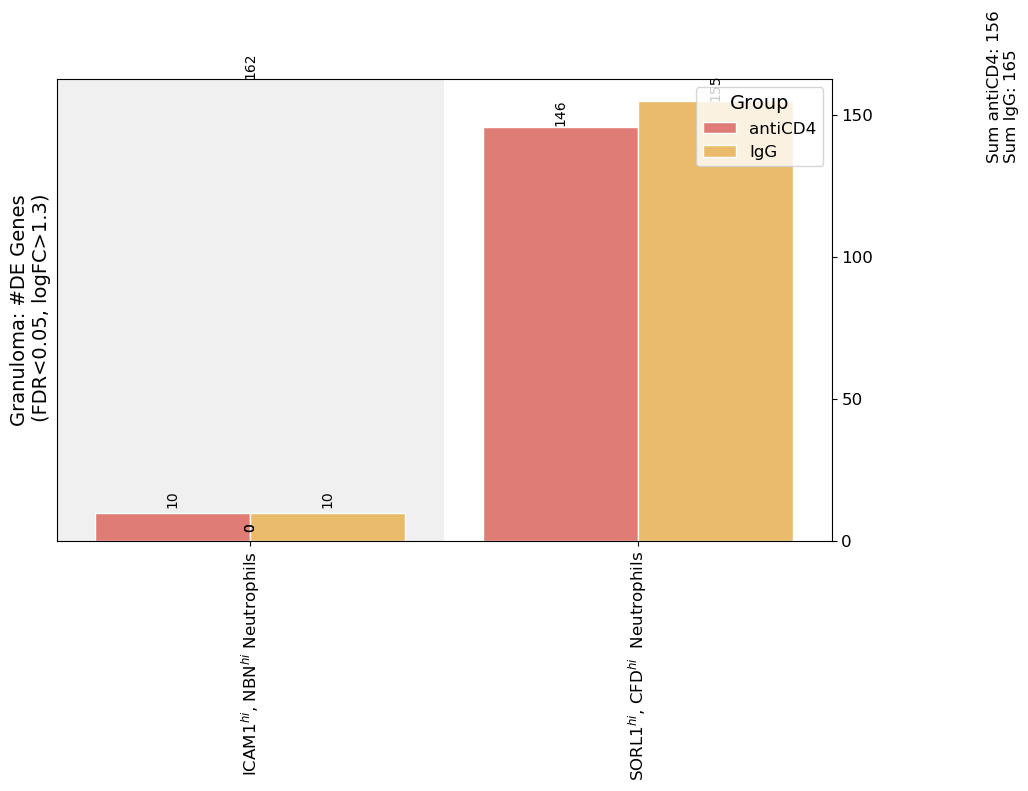

In [8]:
# Plot antiCD4 vs. IgG DE genes
plot_path_anticd4_vs_igg = './Reinfection_Figures_For_Publication/Figure6/Neuts_Associated_Supplemental_NumDEgenes_aCD4vIgG.png'
plot_de_genes(df_anticd4, 'antiCD4', 'IgG', plot_path_anticd4_vs_igg, sum_anticd4, sum_igG_anticd4)